<a href="https://colab.research.google.com/github/OlegLaiok/Comp_Lingv/blob/homework8/%D0%9B%D0%B0%D0%B18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy2
import json
import networkx as nx
import pymorphy2
import collections
from collections import Counter
import matplotlib.pyplot as plt

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 8.2MB 4.7MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
with open("/content/drive/MyDrive/Colab Notebooks/tokens.json", "r", encoding ='utf-8') as f:
    text_data = json.load(f)

Для создания графа по самым частотным словам в корпусе я взял данные из 1-4 лабораторной работы - новости из новостного паблика "Лентач"

In [10]:
morph = pymorphy2.MorphAnalyzer()
text_data1=[]
for doc in text_data:
    n_doc=[]
    for word in doc:
        if morph.parse(word)[0].tag.POS == 'NOUN': #оставляем в каждом документе только сущетвительные
            n_doc.append(word)
    text_data1.append(n_doc)

In [11]:
lem = []
for doc in text_data1: #лемматизация токенов
    doc = [morph.parse(word)[0].normal_form for word in doc]
    lem.append(doc)

После нескольких тестов я выявил стоп слова для данного корпуса. Данные слова особо не отражают суть документа, поэтому их удаляем из обновленного корпуса.

In [12]:
s_w = ['неделя','час', 'сводка','москва','санкт-петербург','регион', 'сутки','время', 'сми','область', 'месяц', 'год','день','март', 'апрель', 'радиолентач', 'человек','дом', 'город', 'житель', 'страна', 'новость','случай','слово']
clear=[] 
for doc in lem:
    for word in doc:
        if word not in s_w:
            clear.append(word)
counted = collections.Counter()
for word in clear: #составляем словарь где каждому слову соответсвует число его вхождений в документ
    counted[word] += 1
counted = list(counted.most_common(20)) #для графа возьмем 20 самых встречающихся
print(counted)

[('коронавирус', 321), ('россия', 206), ('вакцина', 168), ('вакцинация', 82), ('спутник', 75), ('власть', 71), ('сша', 65), ('россиянин', 57), ('ребёнок', 53), ('компания', 51), ('пандемия', 49), ('дело', 47), ('исход', 47), ('работа', 46), ('рубль', 46), ('суд', 43), ('ограничение', 42), ('мужчина', 38), ('мир', 38), ('число', 38)]


In [16]:
top_words = []
nodes_sizes = []
for word in counted:
    top_words.append(word[0]) #здесь хранятся названия вершин
    nodes_sizes.append(word[1]) # здесь хранится вес вершин
nodes_sizes = list(map(lambda x: x*20, nodes_sizes)) #немного увеличим вес вершин для лучшей наглядности

In [17]:
edges = []
for i in range(len(top_words)):
    for j in range(i+1,len(top_words)):
        num = 0
        for doc in lem:
            if top_words[i] and top_words[j] in doc:
                num += 1
        edges.append((top_words[i], top_words[j], num)) #записываем грани в формате (первое слово, второе слово, количесво связей этих слов (количество пар))
edges = [edge for edge in edges if edge[2] >= 2] # устраняем связи вес которых меньше двух

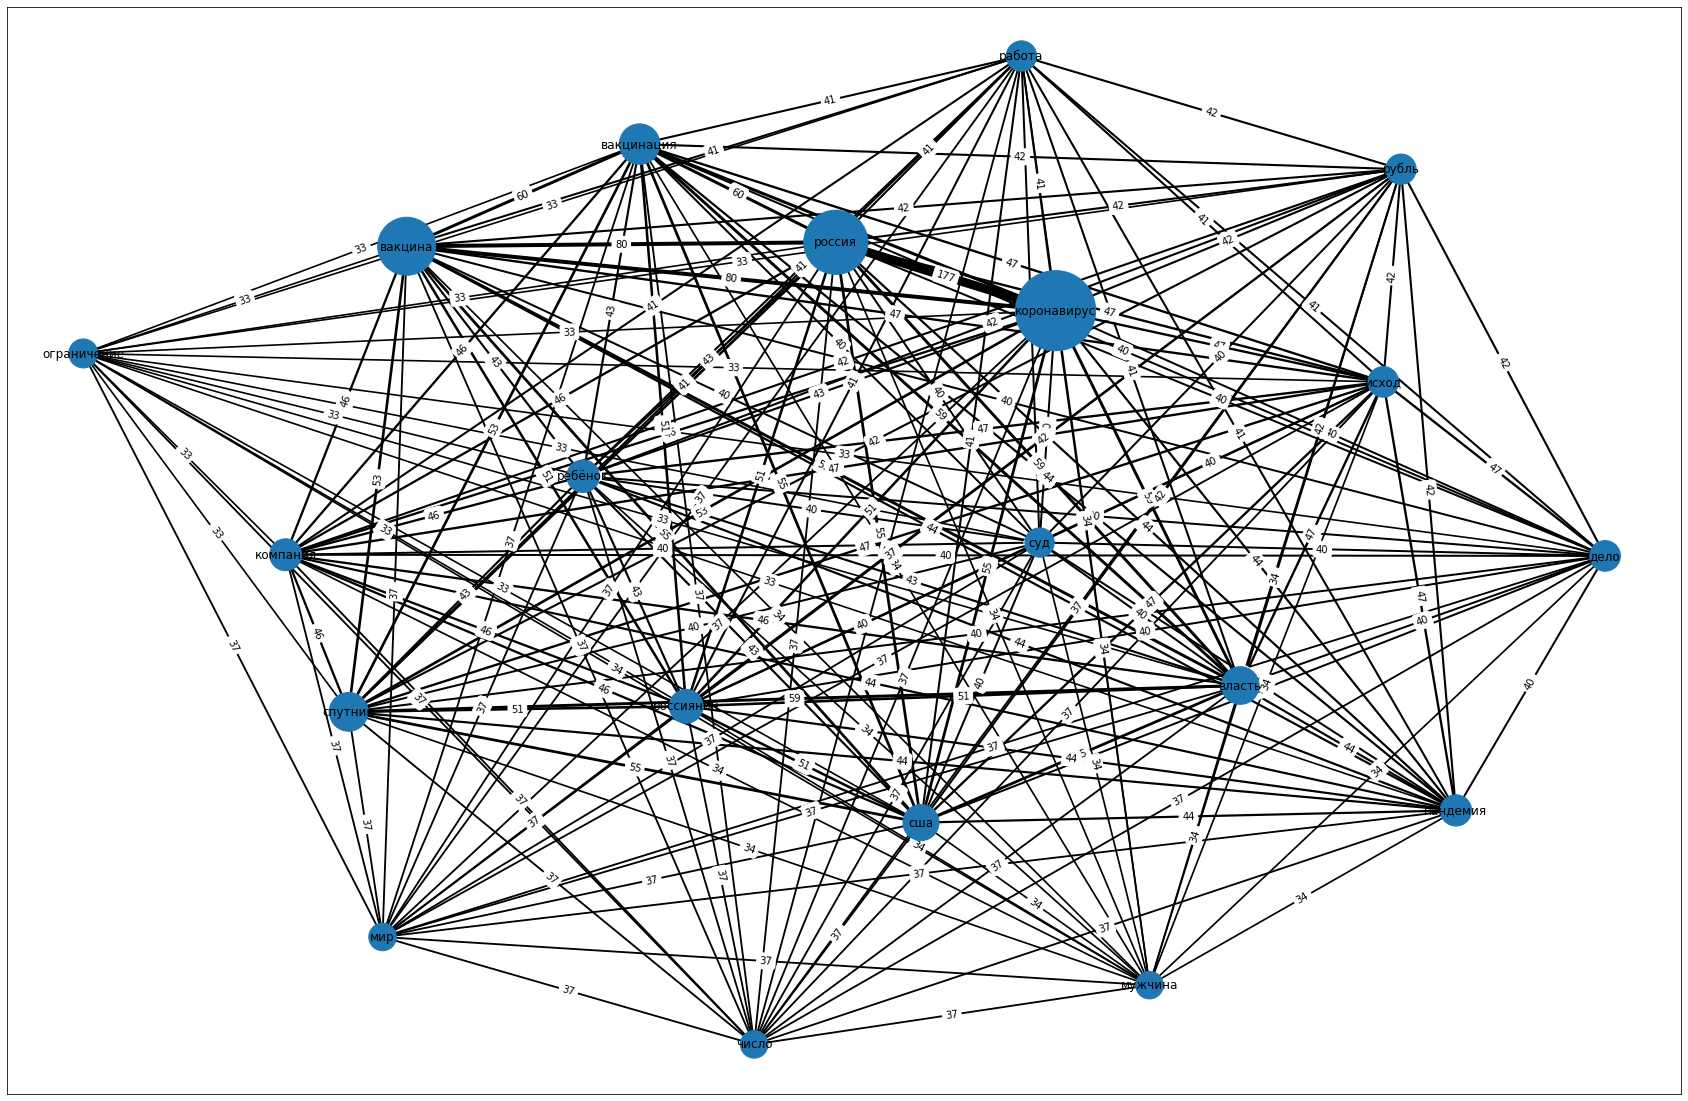

In [21]:
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G)
labels = {}
for i in edges:
    labels[(i[0],i[1])] = i[2]
widths = list(map(lambda x: x*0.05, list(labels.values()))) #указываем толщину ребер, основываясь на их весе
plt.figure(figsize=(30,20))
nx.draw_networkx(G, pos, node_size=nodes_sizes, with_labels=True, width=widths)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

Глядя на этот граф, даже без тематического моделирования можно определить самые популярные темы новостей. К сожалению, в моих данных трудно сказать, какие именно слова являются стоп словами, однако даже по этим словам можно составить примерную карту тем в новостях